# indicators

In [1]:
import vectorbt as vbt

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from numba import njit
import itertools
import talib
import ta

In [3]:
# Disable caching for performance testing
vbt.settings.caching['enabled'] = False

In [4]:
close = pd.DataFrame({
    'a': [1., 2., 3., 4., 5.],
    'b': [5., 4., 3., 2., 1.],
    'c': [1., 2., 3., 2., 1.]
}, index=pd.DatetimeIndex([
    datetime(2018, 1, 1),
    datetime(2018, 1, 2),
    datetime(2018, 1, 3),
    datetime(2018, 1, 4),
    datetime(2018, 1, 5)
]))
np.random.seed(42)
high = close * np.random.uniform(1, 1.1, size=close.shape)
low = close * np.random.uniform(0.9, 1, size=close.shape)
volume = close * 0 + np.random.randint(1, 10, size=close.shape).astype(float)

In [5]:
big_close = pd.DataFrame(np.random.randint(10, size=(1000, 1000)).astype(float))
big_close.index = [datetime(2018, 1, 1) + timedelta(days=i) for i in range(1000)]
big_high = big_close * np.random.uniform(1, 1.1, size=big_close.shape)
big_low = big_close * np.random.uniform(0.9, 1, size=big_close.shape)
big_volume = big_close * 0 + np.random.randint(10, 100, size=big_close.shape).astype(float)

In [6]:
close_ts = pd.Series([1, 2, 3, 4, 3, 2, 1], index=pd.DatetimeIndex([
    datetime(2018, 1, 1),
    datetime(2018, 1, 2),
    datetime(2018, 1, 3),
    datetime(2018, 1, 4),
    datetime(2018, 1, 5),
    datetime(2018, 1, 6),
    datetime(2018, 1, 7)
]))
high_ts = close_ts * 1.1
low_ts = close_ts * 0.9
volume_ts = pd.Series([4, 3, 2, 1, 2, 3, 4], index=close_ts.index)

## IndicatorFactory

In [7]:
def apply_func(i, ts, p, a, b=100):
    return ts * p[i] + a + b

@njit
def apply_func_nb(i, ts, p, a, b):
    return ts * p[i] + a + b # numba doesn't support **kwargs

# Custom function can be anything that takes time series, params and other arguments, and returns outputs
def custom_func(ts, p, *args, **kwargs):
    return vbt.base.combine_fns.apply_and_concat_one(len(p), apply_func, ts, p, *args, **kwargs)

@njit
def custom_func_nb(ts, p, *args):
    return vbt.base.combine_fns.apply_and_concat_one_nb(len(p), apply_func_nb, ts, p, *args)

F = vbt.IndicatorFactory(input_names=['ts'], param_names=['p'], output_names=['out'])
print(F.from_custom_func(custom_func, var_args=True)
      .run(close, [0, 1], 10, b=100).out)
print(F.from_custom_func(custom_func_nb, var_args=True)
      .run(close, [0, 1], 10, 100).out)

custom_p        0                    1              
                a      b      c      a      b      c
2018-01-01  110.0  110.0  110.0  111.0  115.0  111.0
2018-01-02  110.0  110.0  110.0  112.0  114.0  112.0
2018-01-03  110.0  110.0  110.0  113.0  113.0  113.0
2018-01-04  110.0  110.0  110.0  114.0  112.0  112.0
2018-01-05  110.0  110.0  110.0  115.0  111.0  111.0
custom_p        0                    1              
                a      b      c      a      b      c
2018-01-01  110.0  110.0  110.0  111.0  115.0  111.0
2018-01-02  110.0  110.0  110.0  112.0  114.0  112.0
2018-01-03  110.0  110.0  110.0  113.0  113.0  113.0
2018-01-04  110.0  110.0  110.0  114.0  112.0  112.0
2018-01-05  110.0  110.0  110.0  115.0  111.0  111.0


In [8]:
# Apply function is performed on each parameter individually, and each output is then stacked for you
# Apply functions are less customizable than custom functions, but are simpler to write
def apply_func(ts, p, a, b=100):
    return ts * p + a + b

@njit
def apply_func_nb(ts, p, a, b):
    return ts * p + a + b  # numba doesn't support **kwargs
     
F = vbt.IndicatorFactory(input_names=['ts'], param_names=['p'], output_names=['out'])
print(F.from_apply_func(apply_func, var_args=True)
      .run(close, [0, 1], 10, b=100).out)
print(F.from_apply_func(apply_func_nb, var_args=True)
      .run(close, [0, 1], 10, 100).out)

custom_p        0                    1              
                a      b      c      a      b      c
2018-01-01  110.0  110.0  110.0  111.0  115.0  111.0
2018-01-02  110.0  110.0  110.0  112.0  114.0  112.0
2018-01-03  110.0  110.0  110.0  113.0  113.0  113.0
2018-01-04  110.0  110.0  110.0  114.0  112.0  112.0
2018-01-05  110.0  110.0  110.0  115.0  111.0  111.0
custom_p        0                    1              
                a      b      c      a      b      c
2018-01-01  110.0  110.0  110.0  111.0  115.0  111.0
2018-01-02  110.0  110.0  110.0  112.0  114.0  112.0
2018-01-03  110.0  110.0  110.0  113.0  113.0  113.0
2018-01-04  110.0  110.0  110.0  114.0  112.0  112.0
2018-01-05  110.0  110.0  110.0  115.0  111.0  111.0


In [9]:
# test *args
F = vbt.IndicatorFactory(input_names=['ts'], param_names=['p'], output_names=['out'])
print(F.from_apply_func(lambda ts, p, a: ts * p + a, var_args=True)
      .run(close, [0, 1, 2], 3).out) 
print(F.from_apply_func(njit(lambda ts, p, a: ts * p + a), var_args=True)
      .run(close, [0, 1, 2], 3).out)

custom_p      0              1               2           
              a    b    c    a    b    c     a     b    c
2018-01-01  3.0  3.0  3.0  4.0  8.0  4.0   5.0  13.0  5.0
2018-01-02  3.0  3.0  3.0  5.0  7.0  5.0   7.0  11.0  7.0
2018-01-03  3.0  3.0  3.0  6.0  6.0  6.0   9.0   9.0  9.0
2018-01-04  3.0  3.0  3.0  7.0  5.0  5.0  11.0   7.0  7.0
2018-01-05  3.0  3.0  3.0  8.0  4.0  4.0  13.0   5.0  5.0
custom_p      0              1               2           
              a    b    c    a    b    c     a     b    c
2018-01-01  3.0  3.0  3.0  4.0  8.0  4.0   5.0  13.0  5.0
2018-01-02  3.0  3.0  3.0  5.0  7.0  5.0   7.0  11.0  7.0
2018-01-03  3.0  3.0  3.0  6.0  6.0  6.0   9.0   9.0  9.0
2018-01-04  3.0  3.0  3.0  7.0  5.0  5.0  11.0   7.0  7.0
2018-01-05  3.0  3.0  3.0  8.0  4.0  4.0  13.0   5.0  5.0


In [10]:
# test **kwargs
# Numba doesn't support kwargs out of the box
F = vbt.IndicatorFactory(input_names=['ts'], param_names=['p'], output_names=['out'])
print(F.from_apply_func(lambda ts, p, a=1: ts * p + a)
      .run(close, [0, 1, 2], a=3).out) 

custom_p      0              1               2           
              a    b    c    a    b    c     a     b    c
2018-01-01  3.0  3.0  3.0  4.0  8.0  4.0   5.0  13.0  5.0
2018-01-02  3.0  3.0  3.0  5.0  7.0  5.0   7.0  11.0  7.0
2018-01-03  3.0  3.0  3.0  6.0  6.0  6.0   9.0   9.0  9.0
2018-01-04  3.0  3.0  3.0  7.0  5.0  5.0  11.0   7.0  7.0
2018-01-05  3.0  3.0  3.0  8.0  4.0  4.0  13.0   5.0  5.0


In [11]:
# test no inputs
F = vbt.IndicatorFactory(param_names=['p'], output_names=['out'])
print(F.from_apply_func(lambda p: np.full((3, 3), p))
      .run([0, 1]).out)
print(F.from_apply_func(njit(lambda p: np.full((3, 3), p)))
      .run([0, 1]).out)

custom_p  0        1      
          0  1  2  0  1  2
0         0  0  0  1  1  1
1         0  0  0  1  1  1
2         0  0  0  1  1  1
custom_p  0        1      
          0  1  2  0  1  2
0         0  0  0  1  1  1
1         0  0  0  1  1  1
2         0  0  0  1  1  1


In [12]:
# test no inputs with input_shape, input_index and input_columns
F = vbt.IndicatorFactory(param_names=['p'], output_names=['out'])
print(F.from_apply_func(lambda input_shape, p: np.full(input_shape, p), require_input_shape=True)
      .run((5,), 0).out)
print(F.from_apply_func(njit(lambda input_shape, p: np.full(input_shape, p)), require_input_shape=True)
      .run((5,), 0).out)

print(F.from_apply_func(lambda input_shape, p: np.full(input_shape, p), require_input_shape=True)
      .run((5,), [0, 1]).out)
print(F.from_apply_func(njit(lambda input_shape, p: np.full(input_shape, p)), require_input_shape=True)
      .run((5,), [0, 1]).out)

print(F.from_apply_func(lambda input_shape, p: np.full(input_shape, p), require_input_shape=True)
      .run((5, 3), [0, 1], input_index=close.index, input_columns=close.columns).out)
print(F.from_apply_func(njit(lambda input_shape, p: np.full(input_shape, p)), require_input_shape=True)
      .run((5, 3), [0, 1], input_index=close.index, input_columns=close.columns).out)

0    0
1    0
2    0
3    0
4    0
dtype: int64
0    0
1    0
2    0
3    0
4    0
dtype: int64
custom_p  0  1
0         0  1
1         0  1
2         0  1
3         0  1
4         0  1
custom_p  0  1
0         0  1
1         0  1
2         0  1
3         0  1
4         0  1
custom_p    0        1      
            a  b  c  a  b  c
2018-01-01  0  0  0  1  1  1
2018-01-02  0  0  0  1  1  1
2018-01-03  0  0  0  1  1  1
2018-01-04  0  0  0  1  1  1
2018-01-05  0  0  0  1  1  1
custom_p    0        1      
            a  b  c  a  b  c
2018-01-01  0  0  0  1  1  1
2018-01-02  0  0  0  1  1  1
2018-01-03  0  0  0  1  1  1
2018-01-04  0  0  0  1  1  1
2018-01-05  0  0  0  1  1  1


In [13]:
# test multiple inputs
F = vbt.IndicatorFactory(input_names=['ts1', 'ts2'], param_names=['p'], output_names=['out'])
print(F.from_apply_func(lambda ts1, ts2, p: ts1 * ts2 * p)
      .run(close, high, [0, 1]).out)
print(F.from_apply_func(njit(lambda ts1, ts2, p: ts1 * ts2 * p))
      .run(close, high, [0, 1]).out)

custom_p      0                    1                     
              a    b    c          a          b         c
2018-01-01  0.0  0.0  0.0   1.037454  27.376786  1.073199
2018-01-02  0.0  0.0  0.0   4.239463  16.249630  4.062398
2018-01-03  0.0  0.0  0.0   9.052275   9.779559  9.541004
2018-01-04  0.0  0.0  0.0  17.132916   4.008234  4.387964
2018-01-05  0.0  0.0  0.0  27.081107   1.021234  1.018182
custom_p      0                    1                     
              a    b    c          a          b         c
2018-01-01  0.0  0.0  0.0   1.037454  27.376786  1.073199
2018-01-02  0.0  0.0  0.0   4.239463  16.249630  4.062398
2018-01-03  0.0  0.0  0.0   9.052275   9.779559  9.541004
2018-01-04  0.0  0.0  0.0  17.132916   4.008234  4.387964
2018-01-05  0.0  0.0  0.0  27.081107   1.021234  1.018182


In [14]:
# test no params
F = vbt.IndicatorFactory(input_names=['ts'], output_names=['out'])
print(F.from_apply_func(lambda ts: ts)
      .run(close).out)
print(F.from_apply_func(njit(lambda ts: ts))
      .run(close).out)

              a    b    c
2018-01-01  1.0  5.0  1.0
2018-01-02  2.0  4.0  2.0
2018-01-03  3.0  3.0  3.0
2018-01-04  4.0  2.0  2.0
2018-01-05  5.0  1.0  1.0
              a    b    c
2018-01-01  1.0  5.0  1.0
2018-01-02  2.0  4.0  2.0
2018-01-03  3.0  3.0  3.0
2018-01-04  4.0  2.0  2.0
2018-01-05  5.0  1.0  1.0


In [15]:
# test no inputs and no params
F = vbt.IndicatorFactory(output_names=['out'])
print(F.from_apply_func(lambda: np.full((3, 3), 1))
      .run().out)
print(F.from_apply_func(njit(lambda: np.full((3, 3), 1)))
      .run().out)

   0  1  2
0  1  1  1
1  1  1  1
2  1  1  1
   0  1  2
0  1  1  1
1  1  1  1
2  1  1  1


In [16]:
# test multiple params
F = vbt.IndicatorFactory(input_names=['ts'], param_names=['p1', 'p2'], output_names=['out'])
print(F.from_apply_func(lambda ts, p1, p2: ts * (p1 + p2))
      .run(close, np.asarray([0, 1]), np.asarray([2, 3])).out) 
print(F.from_apply_func(njit(lambda ts, p1, p2: ts * (p1 + p2)))
      .run(close, np.asarray([0, 1]), np.asarray([2, 3])).out)

custom_p1      0                1            
custom_p2      2                3            
               a     b    c     a     b     c
2018-01-01   2.0  10.0  2.0   4.0  20.0   4.0
2018-01-02   4.0   8.0  4.0   8.0  16.0   8.0
2018-01-03   6.0   6.0  6.0  12.0  12.0  12.0
2018-01-04   8.0   4.0  4.0  16.0   8.0   8.0
2018-01-05  10.0   2.0  2.0  20.0   4.0   4.0
custom_p1      0                1            
custom_p2      2                3            
               a     b    c     a     b     c
2018-01-01   2.0  10.0  2.0   4.0  20.0   4.0
2018-01-02   4.0   8.0  4.0   8.0  16.0   8.0
2018-01-03   6.0   6.0  6.0  12.0  12.0  12.0
2018-01-04   8.0   4.0  4.0  16.0   8.0   8.0
2018-01-05  10.0   2.0  2.0  20.0   4.0   4.0


In [17]:
# test param_settings array_like
F = vbt.IndicatorFactory(input_names=['ts'], param_names=['p1', 'p2'], output_names=['out'])
print(F.from_apply_func(lambda ts, p1, p2: ts * (p1 + p2), 
                        param_settings={'p1': {'is_array_like': True}})
      .run(close, np.asarray([0, 1, 2]), np.asarray([2, 3])).out) 
print(F.from_apply_func(njit(lambda ts, p1, p2: ts * (p1 + p2)), 
                        param_settings={'p1': {'is_array_like': True}})
      .run(close, np.asarray([0, 1, 2]), np.asarray([2, 3])).out)

custom_p1  array_0             array_1            
custom_p2        2                   3            
                 a     b     c       a     b     c
2018-01-01     2.0  15.0   4.0     3.0  20.0   5.0
2018-01-02     4.0  12.0   8.0     6.0  16.0  10.0
2018-01-03     6.0   9.0  12.0     9.0  12.0  15.0
2018-01-04     8.0   6.0   8.0    12.0   8.0  10.0
2018-01-05    10.0   3.0   4.0    15.0   4.0   5.0
custom_p1  array_0             array_1            
custom_p2        2                   3            
                 a     b     c       a     b     c
2018-01-01     2.0  15.0   4.0     3.0  20.0   5.0
2018-01-02     4.0  12.0   8.0     6.0  16.0  10.0
2018-01-03     6.0   9.0  12.0     9.0  12.0  15.0
2018-01-04     8.0   6.0   8.0    12.0   8.0  10.0
2018-01-05    10.0   3.0   4.0    15.0   4.0   5.0


In [18]:
# test param_settings bc_to_input
F = vbt.IndicatorFactory(input_names=['ts'], param_names=['p1', 'p2'], output_names=['out'])
print(F.from_apply_func(lambda ts, p1, p2: ts * (p1 + p2), 
                        param_settings={'p1': {'is_array_like': True, 'bc_to_input': True}})
      .run(close, np.asarray([0, 1, 2]), np.asarray([2, 3])).out) 
print(F.from_apply_func(njit(lambda ts, p1, p2: ts * (p1 + p2)), 
                        param_settings={'p1': {'is_array_like': True, 'bc_to_input': True}})
      .run(close, np.asarray([0, 1, 2]), np.asarray([2, 3])).out)

custom_p1  array_0             array_1            
custom_p2        2                   3            
                 a     b     c       a     b     c
2018-01-01     2.0  15.0   4.0     3.0  20.0   5.0
2018-01-02     4.0  12.0   8.0     6.0  16.0  10.0
2018-01-03     6.0   9.0  12.0     9.0  12.0  15.0
2018-01-04     8.0   6.0   8.0    12.0   8.0  10.0
2018-01-05    10.0   3.0   4.0    15.0   4.0   5.0
custom_p1  array_0             array_1            
custom_p2        2                   3            
                 a     b     c       a     b     c
2018-01-01     2.0  15.0   4.0     3.0  20.0   5.0
2018-01-02     4.0  12.0   8.0     6.0  16.0  10.0
2018-01-03     6.0   9.0  12.0     9.0  12.0  15.0
2018-01-04     8.0   6.0   8.0    12.0   8.0  10.0
2018-01-05    10.0   3.0   4.0    15.0   4.0   5.0


In [19]:
# test param product
F = vbt.IndicatorFactory(input_names=['ts'], param_names=['p1', 'p2'], output_names=['out'])
print(F.from_apply_func(lambda ts, p1, p2: ts * (p1 + p2))
      .run(close, [0, 1], [2, 3], param_product=True).out) 
print(F.from_apply_func(njit(lambda ts, p1, p2: ts * (p1 + p2)))
      .run(close, [0, 1], [2, 3], param_product=True).out)

custom_p1      0                                 1                         \
custom_p2      2                3                2                3         
               a     b    c     a     b    c     a     b    c     a     b   
2018-01-01   2.0  10.0  2.0   3.0  15.0  3.0   3.0  15.0  3.0   4.0  20.0   
2018-01-02   4.0   8.0  4.0   6.0  12.0  6.0   6.0  12.0  6.0   8.0  16.0   
2018-01-03   6.0   6.0  6.0   9.0   9.0  9.0   9.0   9.0  9.0  12.0  12.0   
2018-01-04   8.0   4.0  4.0  12.0   6.0  6.0  12.0   6.0  6.0  16.0   8.0   
2018-01-05  10.0   2.0  2.0  15.0   3.0  3.0  15.0   3.0  3.0  20.0   4.0   

custom_p1         
custom_p2         
               c  
2018-01-01   4.0  
2018-01-02   8.0  
2018-01-03  12.0  
2018-01-04   8.0  
2018-01-05   4.0  
custom_p1      0                                 1                         \
custom_p2      2                3                2                3         
               a     b    c     a     b    c     a     b    c     a     b   


In [20]:
# test default params
F = vbt.IndicatorFactory(input_names=['ts'], param_names=['p1', 'p2'], output_names=['out'])
print(F.from_apply_func(lambda ts, p1, p2: ts * (p1 + p2), p2=2)
      .run(close, [0, 1]).out)
print(F.from_apply_func(njit(lambda ts, p1, p2: ts * (p1 + p2)), p2=2)
      .run(close, [0, 1]).out)

custom_p1      0                1           
               a     b    c     a     b    c
2018-01-01   2.0  10.0  2.0   3.0  15.0  3.0
2018-01-02   4.0   8.0  4.0   6.0  12.0  6.0
2018-01-03   6.0   6.0  6.0   9.0   9.0  9.0
2018-01-04   8.0   4.0  4.0  12.0   6.0  6.0
2018-01-05  10.0   2.0  2.0  15.0   3.0  3.0
custom_p1      0                1           
               a     b    c     a     b    c
2018-01-01   2.0  10.0  2.0   3.0  15.0  3.0
2018-01-02   4.0   8.0  4.0   6.0  12.0  6.0
2018-01-03   6.0   6.0  6.0   9.0   9.0  9.0
2018-01-04   8.0   4.0  4.0  12.0   6.0  6.0
2018-01-05  10.0   2.0  2.0  15.0   3.0  3.0


In [21]:
# test hide_params
F = vbt.IndicatorFactory(input_names=['ts'], param_names=['p1', 'p2'], output_names=['out'])
print(F.from_apply_func(lambda ts, p1, p2: ts * (p1 + p2), hide_params=['p2'])
      .run(close, [0, 1], 2).out)
print(F.from_apply_func(njit(lambda ts, p1, p2: ts * (p1 + p2)), hide_params=['p2'])
      .run(close, [0, 1], 2).out)

custom_p1      0                1           
               a     b    c     a     b    c
2018-01-01   2.0  10.0  2.0   3.0  15.0  3.0
2018-01-02   4.0   8.0  4.0   6.0  12.0  6.0
2018-01-03   6.0   6.0  6.0   9.0   9.0  9.0
2018-01-04   8.0   4.0  4.0  12.0   6.0  6.0
2018-01-05  10.0   2.0  2.0  15.0   3.0  3.0
custom_p1      0                1           
               a     b    c     a     b    c
2018-01-01   2.0  10.0  2.0   3.0  15.0  3.0
2018-01-02   4.0   8.0  4.0   6.0  12.0  6.0
2018-01-03   6.0   6.0  6.0   9.0   9.0  9.0
2018-01-04   8.0   4.0  4.0  12.0   6.0  6.0
2018-01-05  10.0   2.0  2.0  15.0   3.0  3.0


In [22]:
# test hide_default
F = vbt.IndicatorFactory(input_names=['ts'], param_names=['p1', 'p2'], output_names=['out'])
print(F.from_apply_func(lambda ts, p1, p2: ts * (p1 + p2), p2=2)
      .run(close, [0, 1], hide_default=False).out)
print(F.from_apply_func(njit(lambda ts, p1, p2: ts * (p1 + p2)), p2=2)
      .run(close, [0, 1], hide_default=False).out)
print(F.from_apply_func(lambda ts, p1, p2: ts * (p1 + p2), p2=2)
      .run(close, [0, 1], hide_default=True).out)
print(F.from_apply_func(njit(lambda ts, p1, p2: ts * (p1 + p2)), p2=2)
      .run(close, [0, 1], hide_default=True).out)

custom_p1      0                1           
custom_p2      2                2           
               a     b    c     a     b    c
2018-01-01   2.0  10.0  2.0   3.0  15.0  3.0
2018-01-02   4.0   8.0  4.0   6.0  12.0  6.0
2018-01-03   6.0   6.0  6.0   9.0   9.0  9.0
2018-01-04   8.0   4.0  4.0  12.0   6.0  6.0
2018-01-05  10.0   2.0  2.0  15.0   3.0  3.0
custom_p1      0                1           
custom_p2      2                2           
               a     b    c     a     b    c
2018-01-01   2.0  10.0  2.0   3.0  15.0  3.0
2018-01-02   4.0   8.0  4.0   6.0  12.0  6.0
2018-01-03   6.0   6.0  6.0   9.0   9.0  9.0
2018-01-04   8.0   4.0  4.0  12.0   6.0  6.0
2018-01-05  10.0   2.0  2.0  15.0   3.0  3.0
custom_p1      0                1           
               a     b    c     a     b    c
2018-01-01   2.0  10.0  2.0   3.0  15.0  3.0
2018-01-02   4.0   8.0  4.0   6.0  12.0  6.0
2018-01-03   6.0   6.0  6.0   9.0   9.0  9.0
2018-01-04   8.0   4.0  4.0  12.0   6.0  6.0
2018-01-05

In [23]:
# test multiple outputs
F = vbt.IndicatorFactory(input_names=['ts'], param_names=['p'], output_names=['o1', 'o2'])
print(F.from_apply_func(lambda ts, p: (ts * p, ts * p ** 2))
      .run(close, [0, 1]).o1)
print(F.from_apply_func(lambda ts, p: (ts * p, ts * p ** 2))
      .run(close, [0, 1]).o2)
print(F.from_apply_func(njit(lambda ts, p: (ts * p, ts * p ** 2)))
      .run(close, [0, 1]).o1)
print(F.from_apply_func(njit(lambda ts, p: (ts * p, ts * p ** 2)))
      .run(close, [0, 1]).o2)

custom_p      0              1          
              a    b    c    a    b    c
2018-01-01  0.0  0.0  0.0  1.0  5.0  1.0
2018-01-02  0.0  0.0  0.0  2.0  4.0  2.0
2018-01-03  0.0  0.0  0.0  3.0  3.0  3.0
2018-01-04  0.0  0.0  0.0  4.0  2.0  2.0
2018-01-05  0.0  0.0  0.0  5.0  1.0  1.0
custom_p      0              1          
              a    b    c    a    b    c
2018-01-01  0.0  0.0  0.0  1.0  5.0  1.0
2018-01-02  0.0  0.0  0.0  2.0  4.0  2.0
2018-01-03  0.0  0.0  0.0  3.0  3.0  3.0
2018-01-04  0.0  0.0  0.0  4.0  2.0  2.0
2018-01-05  0.0  0.0  0.0  5.0  1.0  1.0
custom_p      0              1          
              a    b    c    a    b    c
2018-01-01  0.0  0.0  0.0  1.0  5.0  1.0
2018-01-02  0.0  0.0  0.0  2.0  4.0  2.0
2018-01-03  0.0  0.0  0.0  3.0  3.0  3.0
2018-01-04  0.0  0.0  0.0  4.0  2.0  2.0
2018-01-05  0.0  0.0  0.0  5.0  1.0  1.0
custom_p      0              1          
              a    b    c    a    b    c
2018-01-01  0.0  0.0  0.0  1.0  5.0  1.0
2018-01-02  0.0 

In [24]:
# test in-place outputs
def apply_func(ts, ts_out, p):
    ts_out[:, 0] = p
    return ts * p

F = vbt.IndicatorFactory(input_names=['ts'], param_names=['p'], output_names=['out'], in_output_names=['ts_out'])
print(F.from_apply_func(apply_func)
      .run(close, [0, 1]).ts_out)
print(F.from_apply_func(njit(apply_func))
      .run(close, [0, 1]).ts_out)

print(F.from_apply_func(apply_func, in_output_settings={'ts_out': {'dtype': np.int64}})
      .run(close, [0, 1]).ts_out)
print(F.from_apply_func(njit(apply_func), in_output_settings={'ts_out': {'dtype': np.int64}})
      .run(close, [0, 1]).ts_out)

print(F.from_apply_func(apply_func, ts_out=-1)
      .run(close, [0, 1]).ts_out)
print(F.from_apply_func(njit(apply_func), ts_out=-1)
      .run(close, [0, 1]).ts_out)

custom_p      0              1          
              a    b    c    a    b    c
2018-01-01  0.0  0.0  0.0  1.0  0.0  0.0
2018-01-02  0.0  0.0  0.0  1.0  0.0  0.0
2018-01-03  0.0  0.0  0.0  1.0  2.0  3.0
2018-01-04  0.0  5.0  5.0  1.0  3.0  2.0
2018-01-05  0.0  1.0  2.0  1.0  2.0  1.0
custom_p      0              1          
              a    b    c    a    b    c
2018-01-01  0.0  0.0  0.0  1.0  0.0  0.0
2018-01-02  0.0  0.0  0.0  1.0  0.0  0.0
2018-01-03  0.0  0.0  0.0  1.0  2.0  3.0
2018-01-04  0.0  5.0  5.0  1.0  3.0  2.0
2018-01-05  0.0  1.0  2.0  1.0  2.0  1.0
custom_p    0                                            1  \
            a                    b                    c  a   
2018-01-01  0                    0                    0  1   
2018-01-02  0                    0                    0  1   
2018-01-03  0                    0                    0  1   
2018-01-04  0  4617315517961601024  4617315517961601024  1   
2018-01-05  0  4607182418800017408  461168601842738790

In [25]:
# test kwargs_to_args
F = vbt.IndicatorFactory(input_names=['ts'], param_names=['p'], output_names=['out'])
print(F.from_apply_func(lambda ts, p, a, kw: ts * p + a + kw, kwargs_to_args=['kw'], var_args=True)
      .run(close, [0, 1, 2], 3, kw=10).out) 
print(F.from_apply_func(njit(lambda ts, p, a, kw: ts * p + a + kw), kwargs_to_args=['kw'], var_args=True)
      .run(close, [0, 1, 2], 3, kw=10).out)

custom_p       0                 1                 2            
               a     b     c     a     b     c     a     b     c
2018-01-01  13.0  13.0  13.0  14.0  18.0  14.0  15.0  23.0  15.0
2018-01-02  13.0  13.0  13.0  15.0  17.0  15.0  17.0  21.0  17.0
2018-01-03  13.0  13.0  13.0  16.0  16.0  16.0  19.0  19.0  19.0
2018-01-04  13.0  13.0  13.0  17.0  15.0  15.0  21.0  17.0  17.0
2018-01-05  13.0  13.0  13.0  18.0  14.0  14.0  23.0  15.0  15.0
custom_p       0                 1                 2            
               a     b     c     a     b     c     a     b     c
2018-01-01  13.0  13.0  13.0  14.0  18.0  14.0  15.0  23.0  15.0
2018-01-02  13.0  13.0  13.0  15.0  17.0  15.0  17.0  21.0  17.0
2018-01-03  13.0  13.0  13.0  16.0  16.0  16.0  19.0  19.0  19.0
2018-01-04  13.0  13.0  13.0  17.0  15.0  15.0  21.0  17.0  17.0
2018-01-05  13.0  13.0  13.0  18.0  14.0  14.0  23.0  15.0  15.0


In [26]:
# test caching func
F = vbt.IndicatorFactory(input_names=['ts'], param_names=['p'], output_names=['out'])
print(F.from_apply_func(lambda ts, param, c: ts * param + c, cache_func=lambda ts, params: 100)
      .run(close, [0, 1]).out)
print(F.from_apply_func(njit(lambda ts, param, c: ts * param + c), cache_func=njit(lambda ts, params: 100))
      .run(close, [0, 1]).out)

custom_p        0                    1              
                a      b      c      a      b      c
2018-01-01  100.0  100.0  100.0  101.0  105.0  101.0
2018-01-02  100.0  100.0  100.0  102.0  104.0  102.0
2018-01-03  100.0  100.0  100.0  103.0  103.0  103.0
2018-01-04  100.0  100.0  100.0  104.0  102.0  102.0
2018-01-05  100.0  100.0  100.0  105.0  101.0  101.0
custom_p        0                    1              
                a      b      c      a      b      c
2018-01-01  100.0  100.0  100.0  101.0  105.0  101.0
2018-01-02  100.0  100.0  100.0  102.0  104.0  102.0
2018-01-03  100.0  100.0  100.0  103.0  103.0  103.0
2018-01-04  100.0  100.0  100.0  104.0  102.0  102.0
2018-01-05  100.0  100.0  100.0  105.0  101.0  101.0


In [27]:
# test run_combs
F = vbt.IndicatorFactory(input_names=['ts'], param_names=['p1', 'p2'], output_names=['out'])
print(F.from_apply_func(lambda ts, p1, p2: ts * (p1 + p2))
      .run_combs(close, [0, 1, 2], [3, 4, 5], short_names=['i1', 'i2'])[0].out)
print(F.from_apply_func(lambda ts, p1, p2: ts * (p1 + p2))
      .run_combs(close, [0, 1, 2], [3, 4, 5], short_names=['i1', 'i2'])[1].out)
print(F.from_apply_func(njit(lambda ts, p1, p2: ts * (p1 + p2)))
      .run_combs(close, [0, 1, 2], [3, 4, 5], short_names=['i1', 'i2'])[0].out)
print(F.from_apply_func(njit(lambda ts, p1, p2: ts * (p1 + p2)))
      .run_combs(close, [0, 1, 2], [3, 4, 5], short_names=['i1', 'i2'])[1].out)

i1_p1          0                                 1            
i1_p2          3                                 4            
               a     b    c     a     b    c     a     b     c
2018-01-01   3.0  15.0  3.0   3.0  15.0  3.0   5.0  25.0   5.0
2018-01-02   6.0  12.0  6.0   6.0  12.0  6.0  10.0  20.0  10.0
2018-01-03   9.0   9.0  9.0   9.0   9.0  9.0  15.0  15.0  15.0
2018-01-04  12.0   6.0  6.0  12.0   6.0  6.0  20.0  10.0  10.0
2018-01-05  15.0   3.0  3.0  15.0   3.0  3.0  25.0   5.0   5.0
i2_p1          1                 2                              
i2_p2          4                 5                              
               a     b     c     a     b     c     a     b     c
2018-01-01   5.0  25.0   5.0   7.0  35.0   7.0   7.0  35.0   7.0
2018-01-02  10.0  20.0  10.0  14.0  28.0  14.0  14.0  28.0  14.0
2018-01-03  15.0  15.0  15.0  21.0  21.0  21.0  21.0  21.0  21.0
2018-01-04  20.0  10.0  10.0  28.0  14.0  14.0  28.0  14.0  14.0
2018-01-05  25.0   5.0   5.0  35.0   7.0 

In [28]:
from collections import namedtuple

TestEnum = namedtuple('TestEnum', ['Hello', 'World'])(0, 1)
# test attr_settings
F = vbt.IndicatorFactory(
    input_names=['ts'], output_names=['o1', 'o2'], in_output_names=['ts_out'],
    attr_settings={
        'ts': {'dtype': None}, 
        'o1': {'dtype': np.float64}, 
        'o2': {'dtype': np.bool_}, 
        'ts_out': {'dtype': TestEnum}
    }
)
dir(F.from_apply_func(lambda ts, ts_out: (ts + ts_out, ts + ts_out)).run(close))

['__annotations__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_config',
 '_iloc',
 '_in_output_names',
 '_indexing_kwargs',
 '_input_mapper',
 '_input_names',
 '_level_names',
 '_loc',
 '_metrics',
 '_o1',
 '_o2',
 '_output_flags',
 '_output_names',
 '_param_names',
 '_run',
 '_run_combs',
 '_short_name',
 '_ts',
 '_ts_out',
 '_wrapper',
 'apply_func',
 'build_metrics_doc',
 'config',
 'copy',
 'custom_func',
 'deep_getattr',
 'dumps',
 'iloc',
 'in_output_names',
 'indexing_func',
 'indexing_kwargs',
 'input_names',
 'level_names',
 'load',
 'loads',
 'loc',
 'metrics',
 'o1',
 'o1_above',
 'o1_below',
 'o1_equal',
 'o1_stats',
 'o2',
 'o2_and',

In [29]:
CustomInd = vbt.IndicatorFactory(
    input_names=['ts1', 'ts2'],
    param_names=['p1', 'p2'],
    output_names=['o1', 'o2']
).from_apply_func(lambda ts1, ts2, p1, p2: (ts1 * p1, ts2 * p2))

In [30]:
dir(CustomInd) # you can list here all of the available tools

['__annotations__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_in_output_names',
 '_input_names',
 '_metrics',
 '_output_flags',
 '_output_names',
 '_param_names',
 '_run',
 '_run_combs',
 'apply_func',
 'build_metrics_doc',
 'config',
 'copy',
 'custom_func',
 'deep_getattr',
 'dumps',
 'iloc',
 'in_output_names',
 'indexing_func',
 'indexing_kwargs',
 'input_names',
 'level_names',
 'load',
 'loads',
 'loc',
 'metrics',
 'o1',
 'o1_above',
 'o1_below',
 'o1_equal',
 'o1_stats',
 'o2',
 'o2_above',
 'o2_below',
 'o2_equal',
 'o2_stats',
 'output_flags',
 'output_names',
 'override_metrics_doc',
 'p1_list',
 'p1_loc',
 'p2_list',
 'p2_loc',
 'par

In [31]:
custom_ind = CustomInd.run(close, high, [1, 2], [3, 4])
big_custom_ind = CustomInd.run(big_close, big_high, [1, 2], [3, 4])

In [32]:
print(custom_ind.wrapper.index) # subclasses ArrayWrapper
print(custom_ind.wrapper.columns)
print(custom_ind.wrapper.ndim)
print(custom_ind.wrapper.shape)
print(custom_ind.wrapper.freq)

DatetimeIndex(['2018-01-01', '2018-01-02', '2018-01-03', '2018-01-04',
               '2018-01-05'],
              dtype='datetime64[ns]', freq=None)
MultiIndex([(1, 3, 'a'),
            (1, 3, 'b'),
            (1, 3, 'c'),
            (2, 4, 'a'),
            (2, 4, 'b'),
            (2, 4, 'c')],
           names=['custom_p1', 'custom_p2', None])
2
(5, 6)
1 days 00:00:00


In [33]:
# not changed during indexing
print(custom_ind.short_name)
print(custom_ind.level_names)
print(custom_ind.input_names)
print(custom_ind.param_names)
print(custom_ind.output_names)
print(custom_ind.output_flags)
print(custom_ind.p1_list)
print(custom_ind.p2_list)

custom
('custom_p1', 'custom_p2')
('ts1', 'ts2')
('p1', 'p2')
('o1', 'o2')
{}
[1, 2]
[3, 4]


### Pandas indexing

In [34]:
print(custom_ind._ts1)
print(custom_ind.ts1)

print(custom_ind.ts1.iloc[:, 0])
print(custom_ind.iloc[:, 0].ts1)

print(custom_ind.ts1.iloc[:, [0]])
print(custom_ind.iloc[:, [0]].ts1)

print(custom_ind.ts1.iloc[:2, :])
print(custom_ind.iloc[:2, :].ts1)

[[1. 5. 1.]
 [2. 4. 2.]
 [3. 3. 3.]
 [4. 2. 2.]
 [5. 1. 1.]]
custom_p1     1              2          
custom_p2     3              4          
              a    b    c    a    b    c
2018-01-01  1.0  5.0  1.0  1.0  5.0  1.0
2018-01-02  2.0  4.0  2.0  2.0  4.0  2.0
2018-01-03  3.0  3.0  3.0  3.0  3.0  3.0
2018-01-04  4.0  2.0  2.0  4.0  2.0  2.0
2018-01-05  5.0  1.0  1.0  5.0  1.0  1.0
2018-01-01    1.0
2018-01-02    2.0
2018-01-03    3.0
2018-01-04    4.0
2018-01-05    5.0
Name: (1, 3, a), dtype: float64
2018-01-01    1.0
2018-01-02    2.0
2018-01-03    3.0
2018-01-04    4.0
2018-01-05    5.0
Name: (1, 3, a), dtype: float64
custom_p1     1
custom_p2     3
              a
2018-01-01  1.0
2018-01-02  2.0
2018-01-03  3.0
2018-01-04  4.0
2018-01-05  5.0
custom_p1     1
custom_p2     3
              a
2018-01-01  1.0
2018-01-02  2.0
2018-01-03  3.0
2018-01-04  4.0
2018-01-05  5.0
custom_p1     1              2          
custom_p2     3              4          
              a    b    c    

In [35]:
print(custom_ind.o1.iloc[:, 0])
%timeit big_custom_ind.o1.iloc[:, 0] # benchmark, 1 column

print(custom_ind.iloc[:, 0].o1) # performed on the object itself
%timeit big_custom_ind.iloc[:, 0] # slower since it forwards the operation to each dataframe

2018-01-01    1.0
2018-01-02    2.0
2018-01-03    3.0
2018-01-04    4.0
2018-01-05    5.0
Name: (1, 3, a), dtype: float64
120 µs ± 540 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
2018-01-01    1.0
2018-01-02    2.0
2018-01-03    3.0
2018-01-04    4.0
2018-01-05    5.0
Name: (1, 3, a), dtype: float64
1.33 ms ± 40.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [36]:
print(custom_ind.o1.iloc[:, np.arange(3)])
%timeit big_custom_ind.o1.iloc[:, np.arange(1000)] # 1000 columns

print(custom_ind.iloc[:, np.arange(3)].o1)
%timeit big_custom_ind.iloc[:, np.arange(1000)]

custom_p1     1          
custom_p2     3          
              a    b    c
2018-01-01  1.0  5.0  1.0
2018-01-02  2.0  4.0  2.0
2018-01-03  3.0  3.0  3.0
2018-01-04  4.0  2.0  2.0
2018-01-05  5.0  1.0  1.0
910 µs ± 59.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
custom_p1     1          
custom_p2     3          
              a    b    c
2018-01-01  1.0  5.0  1.0
2018-01-02  2.0  4.0  2.0
2018-01-03  3.0  3.0  3.0
2018-01-04  4.0  2.0  2.0
2018-01-05  5.0  1.0  1.0
18 ms ± 759 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [37]:
print(custom_ind.o1.loc[:, (1, 3, 'a')])
%timeit big_custom_ind.o1.loc[:, (1, 3, 0)] # 1 column

print(custom_ind.loc[:, (1, 3, 'a')].o1)
%timeit big_custom_ind.loc[:, (1, 3, 0)]

2018-01-01    1.0
2018-01-02    2.0
2018-01-03    3.0
2018-01-04    4.0
2018-01-05    5.0
Name: (1, 3, a), dtype: float64
147 µs ± 270 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
2018-01-01    1.0
2018-01-02    2.0
2018-01-03    3.0
2018-01-04    4.0
2018-01-05    5.0
Name: (1, 3, a), dtype: float64
1.34 ms ± 4.28 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [38]:
print(custom_ind.o1.loc[:, (1, 3)])
%timeit big_custom_ind.o1.loc[:, 1] # 1000 columns

print(custom_ind.loc[:, (1, 3)].o1)
%timeit big_custom_ind.loc[:, 1]

              a    b    c
2018-01-01  1.0  5.0  1.0
2018-01-02  2.0  4.0  2.0
2018-01-03  3.0  3.0  3.0
2018-01-04  4.0  2.0  2.0
2018-01-05  5.0  1.0  1.0
169 µs ± 1.54 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)
              a    b    c
2018-01-01  1.0  5.0  1.0
2018-01-02  2.0  4.0  2.0
2018-01-03  3.0  3.0  3.0
2018-01-04  4.0  2.0  2.0
2018-01-05  5.0  1.0  1.0
6.1 ms ± 75.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [39]:
print(custom_ind.o1.xs(1, axis=1, level=0))
%timeit big_custom_ind.o1.xs(1, axis=1, level=0) # 1000 columns

print(custom_ind.xs(1, axis=1, level=0).o1)
%timeit big_custom_ind.xs(1, axis=1, level=0)

custom_p2     3          
              a    b    c
2018-01-01  1.0  5.0  1.0
2018-01-02  2.0  4.0  2.0
2018-01-03  3.0  3.0  3.0
2018-01-04  4.0  2.0  2.0
2018-01-05  5.0  1.0  1.0
161 µs ± 371 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
custom_p2     3          
              a    b    c
2018-01-01  1.0  5.0  1.0
2018-01-02  2.0  4.0  2.0
2018-01-03  3.0  3.0  3.0
2018-01-04  4.0  2.0  2.0
2018-01-05  5.0  1.0  1.0
6.2 ms ± 119 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Parameter indexing

In [40]:
# Indexing by parameter
print(custom_ind._p1_mapper)
print(custom_ind.p1_loc[2].o1)
print(custom_ind.p1_loc[1:2].o1)
print(custom_ind.p1_loc[[1, 1, 1]].o1)

Index([1, 1, 1, 2, 2, 2], dtype='int64', name='custom_p1')
custom_p2      4           
               a     b    c
2018-01-01   2.0  10.0  2.0
2018-01-02   4.0   8.0  4.0
2018-01-03   6.0   6.0  6.0
2018-01-04   8.0   4.0  4.0
2018-01-05  10.0   2.0  2.0
custom_p1     1               2           
custom_p2     3               4           
              a    b    c     a     b    c
2018-01-01  1.0  5.0  1.0   2.0  10.0  2.0
2018-01-02  2.0  4.0  2.0   4.0   8.0  4.0
2018-01-03  3.0  3.0  3.0   6.0   6.0  6.0
2018-01-04  4.0  2.0  2.0   8.0   4.0  4.0
2018-01-05  5.0  1.0  1.0  10.0   2.0  2.0
custom_p1     1                                        
custom_p2     3                                        
              a    b    c    a    b    c    a    b    c
2018-01-01  1.0  5.0  1.0  1.0  5.0  1.0  1.0  5.0  1.0
2018-01-02  2.0  4.0  2.0  2.0  4.0  2.0  2.0  4.0  2.0
2018-01-03  3.0  3.0  3.0  3.0  3.0  3.0  3.0  3.0  3.0
2018-01-04  4.0  2.0  2.0  4.0  2.0  2.0  4.0  2.0  2.0
2018-01-0

In [41]:
%timeit big_custom_ind.p1_loc[1] # 1000 columns
%timeit big_custom_ind.p1_loc[np.full(10, 1)] # 10000 columns

18.2 ms ± 1.45 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
122 ms ± 18.2 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [42]:
print(custom_ind._tuple_mapper)
print(custom_ind.tuple_loc[(1, 3)].o1)
print(custom_ind.tuple_loc[(1, 3):(2, 4)].o1)

[(1, 3), (1, 3), (1, 3), (2, 4), (2, 4), (2, 4)]
              a    b    c
2018-01-01  1.0  5.0  1.0
2018-01-02  2.0  4.0  2.0
2018-01-03  3.0  3.0  3.0
2018-01-04  4.0  2.0  2.0
2018-01-05  5.0  1.0  1.0
custom_p1     1               2           
custom_p2     3               4           
              a    b    c     a     b    c
2018-01-01  1.0  5.0  1.0   2.0  10.0  2.0
2018-01-02  2.0  4.0  2.0   4.0   8.0  4.0
2018-01-03  3.0  3.0  3.0   6.0   6.0  6.0
2018-01-04  4.0  2.0  2.0   8.0   4.0  4.0
2018-01-05  5.0  1.0  1.0  10.0   2.0  2.0


In [43]:
%timeit big_custom_ind.tuple_loc[(1, 3)]
%timeit big_custom_ind.tuple_loc[[(1, 3)] * 10]

22.5 ms ± 5.03 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
172 ms ± 10.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### Comparison methods

In [44]:
print(custom_ind.o1 > 2)
%timeit big_custom_ind.o1.values > 2 # don't even try pandas

print(custom_ind.o1_above(2))
%timeit big_custom_ind.o1_above(2) # slower than numpy because of constructing dataframe

custom_p1       1                    2              
custom_p2       3                    4              
                a      b      c      a      b      c
2018-01-01  False   True  False  False   True  False
2018-01-02  False   True  False   True   True   True
2018-01-03   True   True   True   True   True   True
2018-01-04   True  False  False   True   True   True
2018-01-05   True  False  False   True  False  False
485 µs ± 9.08 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
custom_p1       1                    2              
custom_p2       3                    4              
                a      b      c      a      b      c
2018-01-01  False   True  False  False   True  False
2018-01-02  False   True  False   True   True   True
2018-01-03   True   True   True   True   True   True
2018-01-04   True  False  False   True   True   True
2018-01-05   True  False  False   True  False  False
3.32 ms ± 6.22 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [45]:
print(pd.concat((custom_ind.o1 > 2, custom_ind.o1 > 3), axis=1))
%timeit np.hstack((big_custom_ind.o1.values > 2, big_custom_ind.o1.values > 3))

print(custom_ind.o1_above([2, 3]))
%timeit big_custom_ind.o1_above([2, 3])

custom_p1       1                    2                    1                \
custom_p2       3                    4                    3                 
                a      b      c      a      b      c      a      b      c   
2018-01-01  False   True  False  False   True  False  False   True  False   
2018-01-02  False   True  False   True   True   True  False   True  False   
2018-01-03   True   True   True   True   True   True  False  False  False   
2018-01-04   True  False  False   True   True   True   True  False  False   
2018-01-05   True  False  False   True  False  False   True  False  False   

custom_p1       2                
custom_p2       4                
                a      b      c  
2018-01-01  False   True  False  
2018-01-02   True   True   True  
2018-01-03   True   True   True  
2018-01-04   True   True   True  
2018-01-05   True  False  False  
1.37 ms ± 45.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
custom_o1_above      2                

## TA-Lib

In [46]:
ts = pd.DataFrame({
    'a': [1, 2, 3, 4, np.nan],
    'b': [np.nan, 4, 3, 2, 1],
    'c': [1, 2, np.nan, 2, 1]
}, index=pd.DatetimeIndex([
    datetime(2018, 1, 1),
    datetime(2018, 1, 2),
    datetime(2018, 1, 3),
    datetime(2018, 1, 4),
    datetime(2018, 1, 5)
]))

In [47]:
SMA = vbt.talib('SMA')

print(SMA.run(close['a'], 2).real)
print(SMA.run(close, 2).real)
print(SMA.run(close, [2, 3]).real)

2018-01-01    NaN
2018-01-02    1.5
2018-01-03    2.5
2018-01-04    3.5
2018-01-05    4.5
Name: (2, a), dtype: float64
sma_timeperiod    2          
                  a    b    c
2018-01-01      NaN  NaN  NaN
2018-01-02      1.5  4.5  1.5
2018-01-03      2.5  3.5  2.5
2018-01-04      3.5  2.5  2.5
2018-01-05      4.5  1.5  1.5
sma_timeperiod    2              3               
                  a    b    c    a    b         c
2018-01-01      NaN  NaN  NaN  NaN  NaN       NaN
2018-01-02      1.5  4.5  1.5  NaN  NaN       NaN
2018-01-03      2.5  3.5  2.5  2.0  4.0  2.000000
2018-01-04      3.5  2.5  2.5  3.0  3.0  2.333333
2018-01-05      4.5  1.5  1.5  4.0  2.0  2.000000


In [49]:
%timeit SMA.run(big_close)
%timeit SMA.run(big_close, np.arange(2, 10))
%timeit SMA.run(big_close, np.full(10, 2))
%timeit SMA.run(big_close, np.full(10, 2), run_unique=True)

13 ms ± 226 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
80.1 ms ± 1.22 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
99 ms ± 2.78 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
22.3 ms ± 572 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [50]:
comb = itertools.combinations(np.arange(2, 20), 2)
fast_windows, slow_windows = np.asarray(list(comb)).transpose()
print(fast_windows)
print(slow_windows)

[ 2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  2  3  3  3  3  3  3  3
  3  3  3  3  3  3  3  3  3  4  4  4  4  4  4  4  4  4  4  4  4  4  4  4
  5  5  5  5  5  5  5  5  5  5  5  5  5  5  6  6  6  6  6  6  6  6  6  6
  6  6  6  7  7  7  7  7  7  7  7  7  7  7  7  8  8  8  8  8  8  8  8  8
  8  8  9  9  9  9  9  9  9  9  9  9 10 10 10 10 10 10 10 10 10 11 11 11
 11 11 11 11 11 12 12 12 12 12 12 12 13 13 13 13 13 13 14 14 14 14 14 15
 15 15 15 16 16 16 17 17 18]
[ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19  4  5  6  7  8  9 10
 11 12 13 14 15 16 17 18 19  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19
  6  7  8  9 10 11 12 13 14 15 16 17 18 19  7  8  9 10 11 12 13 14 15 16
 17 18 19  8  9 10 11 12 13 14 15 16 17 18 19  9 10 11 12 13 14 15 16 17
 18 19 10 11 12 13 14 15 16 17 18 19 11 12 13 14 15 16 17 18 19 12 13 14
 15 16 17 18 19 13 14 15 16 17 18 19 14 15 16 17 18 19 15 16 17 18 19 16
 17 18 19 17 18 19 18 19 19]


In [51]:
%timeit SMA.run(big_close, fast_windows), SMA.run(big_close, slow_windows) # individual caching
%timeit SMA.run_combs(big_close, np.arange(2, 20)) # mutual caching

4.04 s ± 652 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.51 s ± 287 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [52]:
%timeit vbt.MA.run(big_close, fast_windows), vbt.MA.run(big_close, slow_windows) # the same using Numba
%timeit vbt.MA.run_combs(big_close, np.arange(2, 20))

1.27 s ± 40.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.2 s ± 5.87 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [53]:
sma1, sma2 = SMA.run_combs(close, [2, 3, 4])
print(sma1.real_crossed_above(sma2))
print(sma1.real_crossed_below(sma2))

/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/base/accessors.py:667: RuntimeWarning: invalid value encountered in greater
  result = combine_func(inputs[0], inputs[1], *args, **kwargs)
/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/base/accessors.py:667: RuntimeWarning: invalid value encountered in less
  result = combine_func(inputs[0], inputs[1], *args, **kwargs)


sma_1_timeperiod      2                                         3         \
sma_2_timeperiod      3                    4                    4          
                      a      b      c      a      b      c      a      b   
2018-01-01        False  False  False  False  False  False  False  False   
2018-01-02        False  False  False  False  False  False  False  False   
2018-01-03         True  False   True  False  False  False  False  False   
2018-01-04        False  False  False   True  False   True   True  False   
2018-01-05        False  False  False  False  False  False  False  False   

sma_1_timeperiod         
sma_2_timeperiod         
                      c  
2018-01-01        False  
2018-01-02        False  
2018-01-03        False  
2018-01-04         True  
2018-01-05        False  
sma_1_timeperiod      2                                         3         \
sma_2_timeperiod      3                    4                    4          
                      a      b 

In [54]:
dir(vbt.talib('BBANDS'))

['__annotations__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_in_output_names',
 '_input_names',
 '_metrics',
 '_output_flags',
 '_output_names',
 '_param_names',
 '_run',
 '_run_combs',
 'apply_func',
 'build_metrics_doc',
 'close',
 'close_above',
 'close_below',
 'close_equal',
 'close_stats',
 'config',
 'copy',
 'custom_func',
 'deep_getattr',
 'dumps',
 'iloc',
 'in_output_names',
 'indexing_func',
 'indexing_kwargs',
 'input_names',
 'level_names',
 'load',
 'loads',
 'loc',
 'lowerband',
 'lowerband_above',
 'lowerband_below',
 'lowerband_equal',
 'lowerband_stats',
 'matype_list',
 'matype_loc',
 'metrics',
 'middleband',
 'middleband_a

## MA

In [55]:
print(close.rolling(2).mean())
print(close.ewm(span=3, min_periods=3).mean())
print(vbt.talib('SMA').run(close, timeperiod=2).real)
print(vbt.MA.run(close, [2, 3], ewm=[False, True]).ma)  # adjust=False

              a    b    c
2018-01-01  NaN  NaN  NaN
2018-01-02  1.5  4.5  1.5
2018-01-03  2.5  3.5  2.5
2018-01-04  3.5  2.5  2.5
2018-01-05  4.5  1.5  1.5
                   a         b         c
2018-01-01       NaN       NaN       NaN
2018-01-02       NaN       NaN       NaN
2018-01-03  2.428571  3.571429  2.428571
2018-01-04  3.266667  2.733333  2.200000
2018-01-05  4.161290  1.838710  1.580645
sma_timeperiod    2          
                  a    b    c
2018-01-01      NaN  NaN  NaN
2018-01-02      1.5  4.5  1.5
2018-01-03      2.5  3.5  2.5
2018-01-04      3.5  2.5  2.5
2018-01-05      4.5  1.5  1.5
ma_window      2                 3                
ma_ewm     False              True                
               a    b    c       a       b       c
2018-01-01   NaN  NaN  NaN     NaN     NaN     NaN
2018-01-02   1.5  4.5  1.5     NaN     NaN     NaN
2018-01-03   2.5  3.5  2.5  2.2500  3.7500  2.2500
2018-01-04   3.5  2.5  2.5  3.1250  2.8750  2.1250
2018-01-05   4.5  1.5  1.5  4.0

In [56]:
# One window
%timeit big_close.rolling(2).mean() # pandas
%timeit vbt.talib('SMA').run(big_close, timeperiod=2)
%timeit vbt.MA.run(big_close, 2, return_cache=True) # cache only
%timeit vbt.MA.run(big_close, 2) # with pre+postprocessing and still beats pandas

print(vbt.MA.run(big_close, 2).ma.shape)

49 ms ± 143 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
12.6 ms ± 181 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
7.39 ms ± 58.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
12.5 ms ± 391 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
(1000, 1000)


In [57]:
# Multiple windows
%timeit pd.concat([big_close.rolling(i).mean() for i in np.arange(2, 10)])
%timeit vbt.talib('SMA').run(big_close, np.arange(2, 10))
%timeit vbt.MA.run(big_close, np.arange(2, 10))
%timeit vbt.MA.run(big_close, np.arange(2, 10), run_unique=True)
%timeit vbt.MA.run(big_close, np.arange(2, 10), return_cache=True) # cache only
cache = vbt.MA.run(big_close, np.arange(2, 10), return_cache=True)
%timeit vbt.MA.run(big_close, np.arange(2, 10), use_cache=cache) # using cache

print(vbt.MA.run(big_close, np.arange(2, 10)).ma.shape)

406 ms ± 1.24 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
68.9 ms ± 347 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
64.6 ms ± 181 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
64.3 ms ± 266 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
50.1 ms ± 355 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
37.9 ms ± 3.98 ms per loop (mean ± std. dev. of 7 runs, 100 loops each)
(1000, 8000)


In [58]:
# One window repeated
%timeit pd.concat([big_close.rolling(i).mean() for i in np.full(10, 2)])
%timeit vbt.talib('SMA').run(big_close, np.full(10, 2))
%timeit vbt.MA.run(big_close, np.full(10, 2))
%timeit vbt.MA.run(big_close, np.full(10, 2), run_unique=True)  # slower for large inputs
%timeit vbt.MA.run(big_close, np.full(10, 2), return_cache=True)

print(vbt.MA.run(big_close, np.full(10, 2)).ma.shape)

517 ms ± 6.51 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
88.9 ms ± 3.68 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
25.7 ms ± 61.7 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
26.2 ms ± 188 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
6.61 ms ± 346 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
(1000, 10000)


In [59]:
%timeit pd.concat([big_close.iloc[:, :10].rolling(i).mean() for i in np.full(100, 2)])
%timeit vbt.talib('SMA').run(big_close.iloc[:, :10], np.full(100, 2))
%timeit vbt.MA.run(big_close.iloc[:, :10], np.full(100, 2))
%timeit vbt.MA.run(big_close.iloc[:, :10], np.full(100, 2), run_unique=True)  # faster for smaller inputs
%timeit vbt.MA.run(big_close.iloc[:, :10], np.full(100, 2), return_cache=True)

print(vbt.MA.run(big_close.iloc[:, :10], np.full(100, 2)).ma.shape)

71.6 ms ± 158 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
10.7 ms ± 127 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
4.51 ms ± 57.7 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
4.35 ms ± 36 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
613 µs ± 2.28 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
(1000, 1000)


In [60]:
ma = vbt.MA.run(close, [2, 3], ewm=[False, True])

print(ma.ma)

ma_window      2                 3                
ma_ewm     False              True                
               a    b    c       a       b       c
2018-01-01   NaN  NaN  NaN     NaN     NaN     NaN
2018-01-02   1.5  4.5  1.5     NaN     NaN     NaN
2018-01-03   2.5  3.5  2.5  2.2500  3.7500  2.2500
2018-01-04   3.5  2.5  2.5  3.1250  2.8750  2.1250
2018-01-05   4.5  1.5  1.5  4.0625  1.9375  1.5625


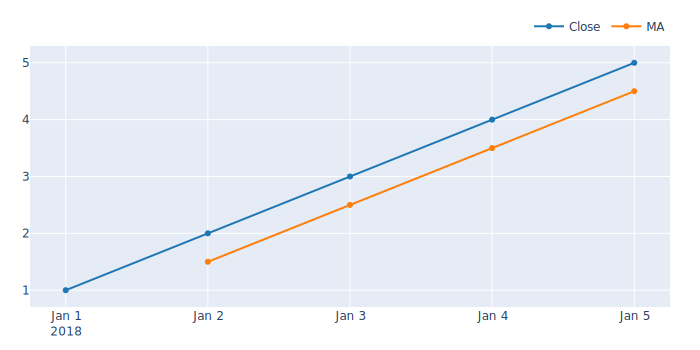

In [61]:
ma[(2, False, 'a')].plot().show_svg()

## MSTD

In [62]:
print(close.rolling(2).std(ddof=0))
print(close.ewm(span=3, min_periods=3).std(ddof=0))
print(vbt.talib('STDDEV').run(close, timeperiod=2).real)  
print(vbt.MSTD.run(close, [2, 3], ewm=[False, True]).mstd)  # adjust=False, ddof=0

              a    b    c
2018-01-01  NaN  NaN  NaN
2018-01-02  0.5  0.5  0.5
2018-01-03  0.5  0.5  0.5
2018-01-04  0.5  0.5  0.5
2018-01-05  0.5  0.5  0.5
                   a         b         c
2018-01-01       NaN       NaN       NaN
2018-01-02       NaN       NaN       NaN
2018-01-03  0.963624  0.963624  0.963624
2018-01-04  1.177164  1.177164  0.686607
2018-01-05  1.345243  1.345243  0.881714
stddev_timeperiod    2          
                     a    b    c
2018-01-01         NaN  NaN  NaN
2018-01-02         0.5  0.5  0.5
2018-01-03         0.5  0.5  0.5
2018-01-04         0.5  0.5  0.5
2018-01-05         0.5  0.5  0.5
mstd_window     2                   3                    
mstd_ewm    False                True                    
                a    b    c         a         b         c
2018-01-01    NaN  NaN  NaN       NaN       NaN       NaN
2018-01-02    0.5  0.5  0.5       NaN       NaN       NaN
2018-01-03    0.5  0.5  0.5  1.048809  1.048809  1.048809
2018-01-04    0.5  

In [63]:
# One window
%timeit big_close.rolling(2).std()
%timeit vbt.talib('STDDEV').run(big_close, timeperiod=2)
%timeit vbt.MSTD.run(big_close, 2)

print(vbt.MSTD.run(big_close, 2).mstd.shape)

65.2 ms ± 486 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
13.7 ms ± 281 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
11.4 ms ± 669 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
(1000, 1000)


In [64]:
# Multiple windows
%timeit pd.concat([big_close.rolling(i).std() for i in np.arange(2, 10)])
%timeit vbt.talib('STDDEV').run(big_close, timeperiod=np.arange(2, 10))
%timeit vbt.MSTD.run(big_close, np.arange(2, 10))

print(vbt.MSTD.run(big_close, np.arange(2, 10)).mstd.shape)

534 ms ± 1.43 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
80.3 ms ± 1.18 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
81.8 ms ± 973 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
(1000, 8000)


In [65]:
# One window repeated
%timeit vbt.talib('STDDEV').run(big_close, timeperiod=np.full(10, 2))
%timeit vbt.MSTD.run(big_close, window=np.full(10, 2))

print(vbt.MSTD.run(big_close, window=np.full(10, 2)).close.shape)

98 ms ± 317 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
27.8 ms ± 44.6 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
(1000, 10000)


In [66]:
mstd = vbt.MSTD.run(close, [2, 3], [False, True])

print(mstd.mstd)

mstd_window     2                   3                    
mstd_ewm    False                True                    
                a    b    c         a         b         c
2018-01-01    NaN  NaN  NaN       NaN       NaN       NaN
2018-01-02    0.5  0.5  0.5       NaN       NaN       NaN
2018-01-03    0.5  0.5  0.5  1.048809  1.048809  1.048809
2018-01-04    0.5  0.5  0.5  1.300183  1.300183  0.740013
2018-01-05    0.5  0.5  0.5  1.469294  1.469294  0.864326


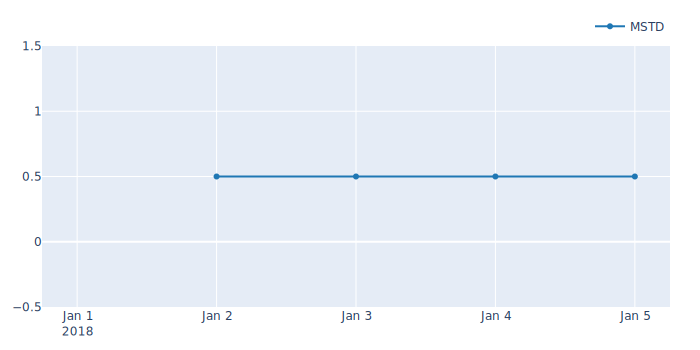

In [67]:
mstd[(2, False, 'a')].plot().show_svg()

## BBANDS

In [68]:
print(vbt.ta('BollingerBands').run(close['a'], window=2, window_dev=2).bollinger_hband)
print(vbt.ta('BollingerBands').run(close['a'], window=2, window_dev=2).bollinger_mavg)
print(vbt.ta('BollingerBands').run(close['a'], window=2, window_dev=2).bollinger_lband)

print(vbt.talib('BBANDS').run(close, timeperiod=2, nbdevup=2, nbdevdn=2).upperband)
print(vbt.talib('BBANDS').run(close, timeperiod=2, nbdevup=2, nbdevdn=2).middleband)
print(vbt.talib('BBANDS').run(close, timeperiod=2, nbdevup=2, nbdevdn=2).lowerband)

print(vbt.BBANDS.run(close, window=2, ewm=False, alpha=2).upper)
print(vbt.BBANDS.run(close, window=2, ewm=False, alpha=2).middle)
print(vbt.BBANDS.run(close, window=2, ewm=False, alpha=2).lower)

2018-01-01    NaN
2018-01-02    2.5
2018-01-03    3.5
2018-01-04    4.5
2018-01-05    5.5
Name: (2, 2, a), dtype: float64
2018-01-01    NaN
2018-01-02    1.5
2018-01-03    2.5
2018-01-04    3.5
2018-01-05    4.5
Name: (2, 2, a), dtype: float64
2018-01-01    NaN
2018-01-02    0.5
2018-01-03    1.5
2018-01-04    2.5
2018-01-05    3.5
Name: (2, 2, a), dtype: float64
bbands_timeperiod    2          
bbands_nbdevup       2          
bbands_nbdevdn       2          
                     a    b    c
2018-01-01         NaN  NaN  NaN
2018-01-02         2.5  5.5  2.5
2018-01-03         3.5  4.5  3.5
2018-01-04         4.5  3.5  3.5
2018-01-05         5.5  2.5  2.5
bbands_timeperiod    2          
bbands_nbdevup       2          
bbands_nbdevdn       2          
                     a    b    c
2018-01-01         NaN  NaN  NaN
2018-01-02         1.5  4.5  1.5
2018-01-03         2.5  3.5  2.5
2018-01-04         3.5  2.5  2.5
2018-01-05         4.5  1.5  1.5
bbands_timeperiod    2          
bbands_

In [69]:
# One window
%timeit vbt.talib('BBANDS').run(big_close, timeperiod=2)
%timeit vbt.BBANDS.run(big_close, window=2)

print(vbt.BBANDS.run(big_close).close.shape)

23 ms ± 367 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
21.6 ms ± 412 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
(1000, 1000)


In [70]:
# Multiple windows
%timeit vbt.talib('BBANDS').run(big_close, timeperiod=np.arange(2, 10))
%timeit vbt.BBANDS.run(big_close, window=np.arange(2, 10))

print(vbt.BBANDS.run(big_close, window=np.arange(2, 10)).close.shape)

192 ms ± 1.9 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
185 ms ± 1.42 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
(1000, 8000)


In [71]:
# One window repeated
%timeit vbt.talib('BBANDS').run(big_close, timeperiod=np.full(10, 2))
%timeit vbt.BBANDS.run(big_close, window=np.full(10, 2))

print(vbt.BBANDS.run(big_close, window=np.full(10, 2)).close.shape)

215 ms ± 1.51 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
100 ms ± 1.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
(1000, 10000)


In [72]:
bb = vbt.BBANDS.run(close, window=2, alpha=[1., 2.], ewm=False)

print(bb.middle)
print()
print(bb.upper)
print()
print(bb.lower)
print()
print(bb.percent_b)
print()
print(bb.bandwidth)

bb_window      2                         
bb_ewm     False                         
bb_alpha     1.0            2.0          
               a    b    c    a    b    c
2018-01-01   NaN  NaN  NaN  NaN  NaN  NaN
2018-01-02   1.5  4.5  1.5  1.5  4.5  1.5
2018-01-03   2.5  3.5  2.5  2.5  3.5  2.5
2018-01-04   3.5  2.5  2.5  3.5  2.5  2.5
2018-01-05   4.5  1.5  1.5  4.5  1.5  1.5

bb_window      2                         
bb_ewm     False                         
bb_alpha     1.0            2.0          
               a    b    c    a    b    c
2018-01-01   NaN  NaN  NaN  NaN  NaN  NaN
2018-01-02   2.0  5.0  2.0  2.5  5.5  2.5
2018-01-03   3.0  4.0  3.0  3.5  4.5  3.5
2018-01-04   4.0  3.0  3.0  4.5  3.5  3.5
2018-01-05   5.0  2.0  2.0  5.5  2.5  2.5

bb_window      2                         
bb_ewm     False                         
bb_alpha     1.0            2.0          
               a    b    c    a    b    c
2018-01-01   NaN  NaN  NaN  NaN  NaN  NaN
2018-01-02   1.0  4.0  1.0  0.5 

In [73]:
print(bb.close_below(bb.upper) & bb.close_above(bb.lower)) # price between bands

bb_window       2                                   
bb_ewm      False                                   
bb_alpha      1.0                  2.0              
                a      b      c      a      b      c
2018-01-01  False  False  False  False  False  False
2018-01-02  False  False  False   True   True   True
2018-01-03  False  False  False   True   True   True
2018-01-04  False  False  False   True   True   True
2018-01-05  False  False  False   True   True   True


/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/base/accessors.py:667: RuntimeWarning:

invalid value encountered in less

/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/base/accessors.py:667: RuntimeWarning:

invalid value encountered in greater



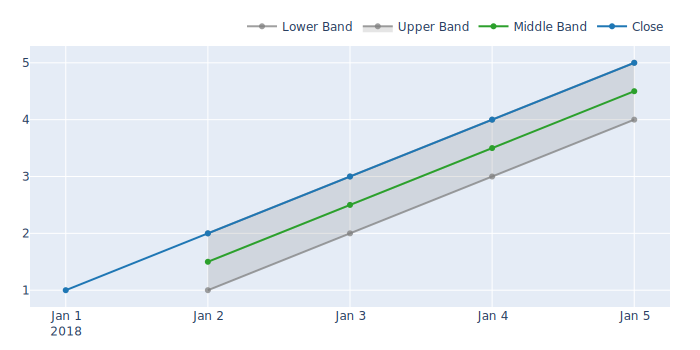

In [74]:
bb[(2, False, 1., 'a')].plot().show_svg()

## RSI

In [75]:
print(vbt.ta('RSIIndicator').run(close=close['a'], window=2).rsi)  # alpha=1/n
print(vbt.ta('RSIIndicator').run(close=close['b'], window=2).rsi)
print(vbt.ta('RSIIndicator').run(close=close['c'], window=2).rsi)
print(vbt.talib('RSI').run(close, timeperiod=2).real)
print(vbt.RSI.run(close, window=[2, 2], ewm=[True, False]).rsi)  # span=n

2018-01-01      NaN
2018-01-02    100.0
2018-01-03    100.0
2018-01-04    100.0
2018-01-05    100.0
Name: (2, a), dtype: float64
2018-01-01    NaN
2018-01-02    0.0
2018-01-03    0.0
2018-01-04    0.0
2018-01-05    0.0
Name: (2, b), dtype: float64
2018-01-01           NaN
2018-01-02    100.000000
2018-01-03    100.000000
2018-01-04     42.857143
2018-01-05     20.000000
Name: (2, c), dtype: float64
rsi_timeperiod      2            
                    a    b      c
2018-01-01        NaN  NaN    NaN
2018-01-02        NaN  NaN    NaN
2018-01-03      100.0  0.0  100.0
2018-01-04      100.0  0.0   50.0
2018-01-05      100.0  0.0   25.0
rsi_window      2                                    
rsi_ewm      True                   False            
                a    b           c      a    b      c
2018-01-01    NaN  NaN         NaN    NaN  NaN    NaN
2018-01-02    NaN  NaN         NaN    NaN  NaN    NaN
2018-01-03  100.0  0.0  100.000000  100.0  0.0  100.0
2018-01-04  100.0  0.0   33.333333  

In [76]:
# One window
%timeit vbt.talib('RSI').run(big_close, timeperiod=2)
%timeit vbt.RSI.run(big_close, window=2)

print(vbt.RSI.run(big_close, window=2).rsi.shape)

19.4 ms ± 149 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
27.6 ms ± 922 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
(1000, 1000)


In [77]:
# Multiple windows
%timeit vbt.talib('RSI').run(big_close, timeperiod=np.arange(2, 10))
%timeit vbt.RSI.run(big_close, window=np.arange(2, 10))

print(vbt.RSI.run(big_close, window=np.arange(2, 10)).rsi.shape)

128 ms ± 253 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
139 ms ± 244 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
(1000, 8000)


In [78]:
# One window repeated
%timeit vbt.talib('RSI').run(big_close, timeperiod=np.full(10, 2))
%timeit vbt.RSI.run(big_close, window=np.full(10, 2))

print(vbt.RSI.run(big_close, window=np.full(10, 2)).rsi.shape)

160 ms ± 214 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
53.6 ms ± 137 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
(1000, 10000)


In [79]:
rsi = vbt.RSI.run(close, window=[2, 3], ewm=[False, True])

print(rsi.rsi)

rsi_window      2                  3           
rsi_ewm     False               True           
                a    b      c      a    b     c
2018-01-01    NaN  NaN    NaN    NaN  NaN   NaN
2018-01-02    NaN  NaN    NaN    NaN  NaN   NaN
2018-01-03  100.0  0.0  100.0    NaN  NaN   NaN
2018-01-04  100.0  0.0   50.0  100.0  0.0  50.0
2018-01-05  100.0  0.0    0.0  100.0  0.0  25.0


In [80]:
print(rsi.rsi_above(70))

rsi_window      2                    3              
rsi_ewm     False                 True              
                a      b      c      a      b      c
2018-01-01  False  False  False  False  False  False
2018-01-02  False  False  False  False  False  False
2018-01-03   True  False   True  False  False  False
2018-01-04   True  False  False   True  False  False
2018-01-05   True  False  False   True  False  False


/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/base/accessors.py:667: RuntimeWarning:

invalid value encountered in greater



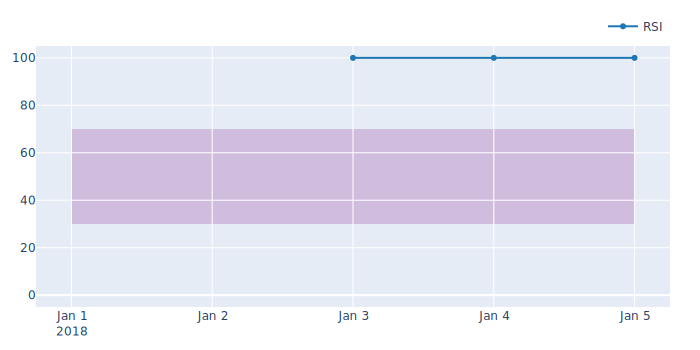

In [81]:
rsi[(2, False, 'a')].plot().show_svg()

## STOCH

In [82]:
print(vbt.ta('StochasticOscillator').run(high=high['a'], low=low['a'], close=close['a'], window=2, smooth_window=3).stoch)
print(vbt.ta('StochasticOscillator').run(high=high['a'], low=low['a'], close=close['a'], window=2, smooth_window=3).stoch_signal)
print(vbt.talib('STOCHF').run(high, low, close, fastk_period=2, fastd_period=3).fastk)
print(vbt.talib('STOCHF').run(high, low, close, fastk_period=2, fastd_period=3).fastd)
print(vbt.STOCH.run(high, low, close, k_window=2, d_window=3).percent_k)
print(vbt.STOCH.run(high, low, close, k_window=2, d_window=3).percent_d)

2018-01-01          NaN
2018-01-02    90.033913
2018-01-03    98.459370
2018-01-04    81.624981
2018-01-05    74.524237
Name: (2, 3, a), dtype: float64
2018-01-01          NaN
2018-01-02          NaN
2018-01-03          NaN
2018-01-04    90.039421
2018-01-05    84.869529
Name: (2, 3, a), dtype: float64
stochf_fastk_period          2                     
stochf_fastd_period          3                     
                             a         b          c
2018-01-01                 NaN       NaN        NaN
2018-01-02                 NaN       NaN        NaN
2018-01-03                 NaN       NaN        NaN
2018-01-04           81.624981  3.297837  11.941605
2018-01-05           74.524237  3.900804   7.395659
stochf_fastk_period          2                      
stochf_fastd_period          3                      
                             a          b          c
2018-01-01                 NaN        NaN        NaN
2018-01-02                 NaN        NaN        NaN
2018-01-03     

In [83]:
# One window
%timeit vbt.talib('STOCHF').run(big_high, big_low, big_close, fastk_period=2)
%timeit vbt.STOCH.run(big_high, big_low, big_close, k_window=2)

print(vbt.STOCH.run(big_high, big_low, big_close, k_window=2).percent_d.shape)

29.4 ms ± 199 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
26.6 ms ± 607 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
(1000, 1000)


In [84]:
# Multiple windows
%timeit vbt.talib('STOCHF').run(big_high, big_low, big_close, fastk_period=np.arange(2, 10))
%timeit vbt.STOCH.run(big_high, big_low, big_close, k_window=np.arange(2, 10))

print(vbt.STOCH.run(big_high, big_low, big_close, k_window=np.arange(2, 10)).percent_d.shape)

220 ms ± 234 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
283 ms ± 5.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
(1000, 8000)


In [85]:
# One window repeated
%timeit vbt.talib('STOCHF').run(big_high, big_low, big_close, fastk_period=np.full(10, 2))
%timeit vbt.STOCH.run(big_high, big_low, big_close, k_window=np.full(10, 2))

print(vbt.STOCH.run(big_high, big_low, big_close, k_window=np.full(10, 2)).percent_d.shape)

264 ms ± 672 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
132 ms ± 519 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
(1000, 10000)


In [86]:
stochastic = vbt.STOCH.run(high, low, close, k_window=[2, 4], d_window=2, d_ewm=[False, True])

print(stochastic.percent_k)
print(stochastic.percent_d)

stoch_k_window          2                                4            \
stoch_d_window          2                                2             
stoch_d_ewm         False                             True             
                        a          b          c          a         b   
2018-01-01            NaN        NaN        NaN        NaN       NaN   
2018-01-02      90.033913  16.118819  97.107794        NaN       NaN   
2018-01-03      98.459370  16.658503  85.664573        NaN       NaN   
2018-01-04      81.624981   3.297837  11.941605  91.582811  1.221173   
2018-01-05      74.524237   3.900804   7.395659  88.208468  1.313450   

stoch_k_window             
stoch_d_window             
stoch_d_ewm                
                        c  
2018-01-01            NaN  
2018-01-02            NaN  
2018-01-03            NaN  
2018-01-04      47.019332  
2018-01-05       4.190157  
stoch_k_window          2                                4            \
stoch_d_window          2  

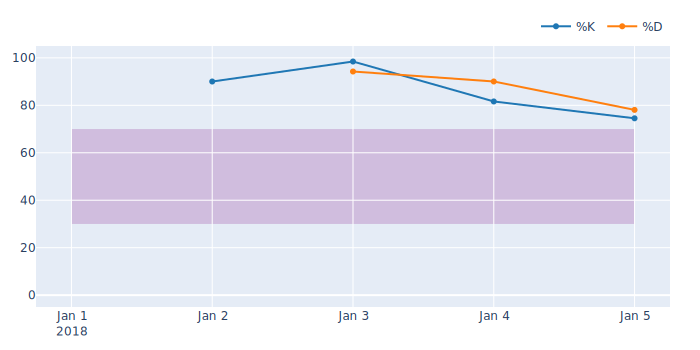

In [87]:
stochastic[(2, 2, False, 'a')].plot().show_svg()

## MACD

In [88]:
print(vbt.ta('MACD').run(close['a'], window_fast=2, window_slow=3, window_sign=2).macd)
print(vbt.ta('MACD').run(close['a'], window_fast=2, window_slow=3, window_sign=2).macd_signal)
print(vbt.ta('MACD').run(close['a'], window_fast=2, window_slow=3, window_sign=2).macd_diff)

print(vbt.talib('MACD').run(close, fastperiod=2, slowperiod=3, signalperiod=2).macd)  # uses sma
print(vbt.talib('MACD').run(close, fastperiod=2, slowperiod=3, signalperiod=2).macdsignal)
print(vbt.talib('MACD').run(close, fastperiod=2, slowperiod=3, signalperiod=2).macdhist)

print(vbt.MACD.run(close, fast_window=2, slow_window=3, signal_window=2, macd_ewm=True, signal_ewm=True).macd)
print(vbt.MACD.run(close, fast_window=2, slow_window=3, signal_window=2, macd_ewm=True, signal_ewm=True).signal)
print(vbt.MACD.run(close, fast_window=2, slow_window=3, signal_window=2, macd_ewm=True, signal_ewm=True).hist)

2018-01-01         NaN
2018-01-02         NaN
2018-01-03    0.305556
2018-01-04    0.393519
2018-01-05    0.443673
Name: (3, 2, 2, a), dtype: float64
2018-01-01         NaN
2018-01-02         NaN
2018-01-03         NaN
2018-01-04    0.364198
2018-01-05    0.417181
Name: (3, 2, 2, a), dtype: float64
2018-01-01         NaN
2018-01-02         NaN
2018-01-03         NaN
2018-01-04    0.029321
2018-01-05    0.026492
Name: (3, 2, 2, a), dtype: float64
macd_fastperiod      2               
macd_slowperiod      3               
macd_signalperiod    2               
                     a    b         c
2018-01-01         NaN  NaN       NaN
2018-01-02         NaN  NaN       NaN
2018-01-03         NaN  NaN       NaN
2018-01-04         0.5 -0.5  0.166667
2018-01-05         0.5 -0.5 -0.111111
macd_fastperiod      2               
macd_slowperiod      3               
macd_signalperiod    2               
                     a    b         c
2018-01-01         NaN  NaN       NaN
2018-01-02        

In [89]:
# One window
%timeit vbt.talib('MACD').run(big_close, fastperiod=2)
%timeit vbt.MACD.run(big_close, fast_window=2)

print(vbt.MACD.run(big_close, fast_window=2).macd.shape)

28.4 ms ± 571 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
23.1 ms ± 969 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
(1000, 1000)


In [90]:
# Multiple windows
%timeit vbt.talib('MACD').run(big_close, fastperiod=np.arange(2, 10))
%timeit vbt.MACD.run(big_close, fast_window=np.arange(2, 10))

print(vbt.MACD.run(big_close, fast_window=np.arange(2, 10)).macd.shape)

217 ms ± 2.93 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
145 ms ± 364 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
(1000, 8000)


In [91]:
# One window repeated
%timeit vbt.talib('MACD').run(big_close, fastperiod=np.full(10, 2))
%timeit vbt.MACD.run(big_close, fast_window=np.full(10, 2))

print(vbt.MACD.run(big_close, fast_window=np.full(10, 2)).macd.shape)

267 ms ± 1.33 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
134 ms ± 6.54 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
(1000, 10000)


In [92]:
macd = vbt.MACD.run(close, fast_window=2, slow_window=3, signal_window=[2, 3], macd_ewm=True, signal_ewm=True)

print(macd.macd)
print(macd.signal)
print(macd.hist)

macd_fast_window           2                                                  
macd_slow_window           3                                                  
macd_signal_window         2                             3                    
macd_macd_ewm           True                          True                    
macd_signal_ewm         True                          True                    
                           a         b         c         a         b         c
2018-01-01               NaN       NaN       NaN       NaN       NaN       NaN
2018-01-02               NaN       NaN       NaN       NaN       NaN       NaN
2018-01-03          0.305556 -0.305556  0.305556  0.305556 -0.305556  0.305556
2018-01-04          0.393519 -0.393519  0.060185  0.393519 -0.393519  0.060185
2018-01-05          0.443673 -0.443673 -0.167438  0.443673 -0.443673 -0.167438
macd_fast_window           2                                                  
macd_slow_window           3                        

/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/indicators/basic.py:666: RuntimeWarning:

invalid value encountered in greater

/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/indicators/basic.py:667: RuntimeWarning:

invalid value encountered in greater

/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/indicators/basic.py:667: RuntimeWarning:

invalid value encountered in less_equal

/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/indicators/basic.py:668: RuntimeWarning:

invalid value encountered in less

/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/indicators/basic.py:669: RuntimeWarning:

invalid value encountered in less

/Users/olegpolakow/Documents/SourceTree/vectorbt/vectorbt/indicators/basic.py:669: RuntimeWarning:

invalid value encountered in greater_equal



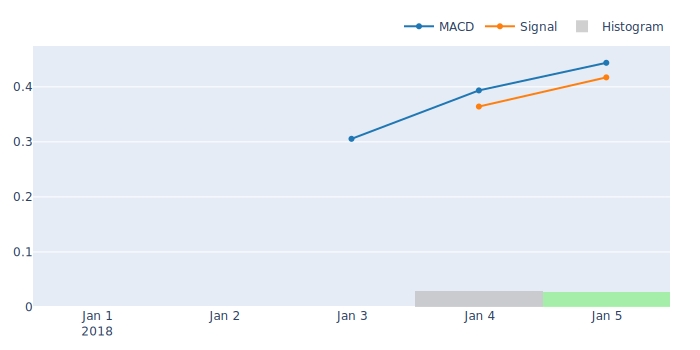

In [93]:
macd[(2, 3, 2, True, True, 'a')].plot().show_svg()

## ATR

In [94]:
print(vbt.ta('AverageTrueRange').run(high['a'], low['a'], close['a'], window=2).average_true_range)
print(vbt.ta('AverageTrueRange').run(high['b'], low['b'], close['b'], window=2).average_true_range)
print(vbt.ta('AverageTrueRange').run(high['c'], low['c'], close['c'], window=2).average_true_range)
print(vbt.talib('ATR').run(high, low, close, timeperiod=2).real)
print(vbt.ATR.run(high, low, close, window=[2, 3], ewm=[False, True]).atr)

2018-01-01    0.000000
2018-01-02    0.619423
2018-01-03    0.818424
2018-01-04    1.050826
2018-01-05    1.233524
Name: (2, a), dtype: float64
2018-01-01    0.000000
2018-01-02    1.053372
2018-01-03    1.132864
2018-01-04    1.087915
2018-01-05    1.064337
Name: (2, b), dtype: float64
2018-01-01    0.000000
2018-01-02    0.575961
2018-01-03    0.878148
2018-01-04    1.019107
2018-01-05    1.057231
Name: (2, c), dtype: float64
atr_timeperiod         2                    
                       a         b         c
2018-01-01           NaN       NaN       NaN
2018-01-02           NaN       NaN       NaN
2018-01-03      1.068578  1.247932  1.105767
2018-01-04      1.175904  1.145449  1.132916
2018-01-05      1.296063  1.093104  1.114135
atr_window         2                             3                    
atr_ewm        False                          True                    
                   a         b         c         a         b         c
2018-01-01       NaN       NaN       NaN

In [95]:
# One window
%timeit vbt.talib('ATR').run(big_high, big_low, big_close, timeperiod=2)
%timeit vbt.ATR.run(big_high, big_low, big_close, window=2)

print(vbt.ATR.run(big_high, big_low, big_close, window=2).atr.shape)

22.5 ms ± 470 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
33.5 ms ± 340 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
(1000, 1000)


In [96]:
# Multiple windows
%timeit vbt.talib('ATR').run(big_high, big_low, big_close, timeperiod=np.arange(2, 10))
%timeit vbt.ATR.run(big_high, big_low, big_close, window=np.arange(2, 10)) # rolling min/max very expensive

print(vbt.ATR.run(big_high, big_low, big_close, window=np.arange(2, 10)).atr.shape)

158 ms ± 695 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
110 ms ± 1.14 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
(1000, 8000)


In [97]:
# One window repeated
%timeit vbt.talib('ATR').run(big_high, big_low, big_close, timeperiod=np.full(10, 2))
%timeit vbt.ATR.run(big_high, big_low, big_close, window=np.full(10, 2))

print(vbt.ATR.run(big_high, big_low, big_close, window=np.full(10, 2)).atr.shape)

197 ms ± 1.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
67.5 ms ± 1.89 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
(1000, 10000)


In [98]:
atr = vbt.ATR.run(high, low, close, window=[2, 3], ewm=[False, True])

print(atr.tr)
print(atr.atr)

atr_window         2                             3                    
atr_ewm        False                          True                    
                   a         b         c         a         b         c
2018-01-01  0.119114  0.823236  0.120724  0.119114  0.823236  0.120724
2018-01-02  1.119732  1.283508  1.031199  1.119732  1.283508  1.031199
2018-01-03  1.017425  1.212357  1.180335  1.017425  1.212357  1.180335
2018-01-04  1.283229  1.042965  1.160065  1.283229  1.042965  1.160065
2018-01-05  1.416221  1.040759  1.095355  1.416221  1.040759  1.095355
atr_window         2                             3                    
atr_ewm        False                          True                    
                   a         b         c         a         b         c
2018-01-01       NaN       NaN       NaN       NaN       NaN       NaN
2018-01-02  0.619423  1.053372  0.575961       NaN       NaN       NaN
2018-01-03  1.068578  1.247932  1.105767  0.818424  1.132864  0.878148
2018-0

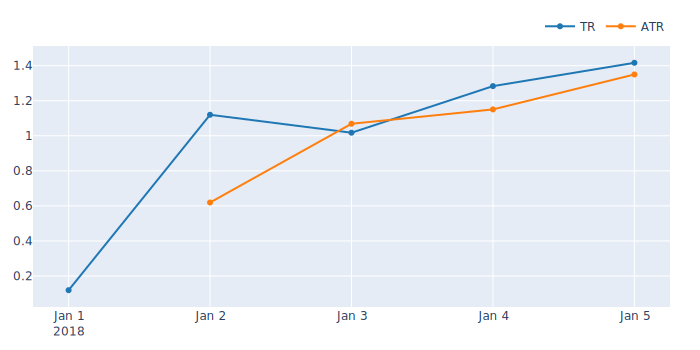

In [99]:
atr[(2, False, 'a')].plot().show_svg()

## OBV

In [100]:
print(vbt.ta('OnBalanceVolumeIndicator').run(close['a'], volume['a']).on_balance_volume)
print(vbt.ta('OnBalanceVolumeIndicator').run(close['b'], volume['b']).on_balance_volume)
print(vbt.ta('OnBalanceVolumeIndicator').run(close['c'], volume['c']).on_balance_volume)
print(vbt.talib('OBV').run(close, volume).real)
print(vbt.OBV.run(close, volume).obv)

2018-01-01     3.0
2018-01-02    12.0
2018-01-03    16.0
2018-01-04    25.0
2018-01-05    29.0
Name: a, dtype: float64
2018-01-01     7.0
2018-01-02     0.0
2018-01-03    -9.0
2018-01-04   -14.0
2018-01-05   -21.0
Name: b, dtype: float64
2018-01-01    5.0
2018-01-02    7.0
2018-01-03    9.0
2018-01-04    7.0
2018-01-05   -1.0
Name: c, dtype: float64
               a     b    c
2018-01-01   3.0   7.0  5.0
2018-01-02  12.0   0.0  7.0
2018-01-03  16.0  -9.0  9.0
2018-01-04  25.0 -14.0  7.0
2018-01-05  29.0 -21.0 -1.0
               a     b    c
2018-01-01   3.0   7.0  5.0
2018-01-02  12.0   0.0  7.0
2018-01-03  16.0  -9.0  9.0
2018-01-04  25.0 -14.0  7.0
2018-01-05  29.0 -21.0 -1.0


In [101]:
%timeit vbt.talib('OBV').run(big_close, big_volume)
%timeit vbt.OBV.run(big_close, big_volume)

print(vbt.OBV.run(big_close, big_volume).obv.shape)

19.3 ms ± 549 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
17.1 ms ± 1.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
(1000, 1000)


In [102]:
obv = vbt.OBV.run(close, volume)

print(obv.obv)

               a     b    c
2018-01-01   3.0   7.0  5.0
2018-01-02  12.0   0.0  7.0
2018-01-03  16.0  -9.0  9.0
2018-01-04  25.0 -14.0  7.0
2018-01-05  29.0 -21.0 -1.0


In [103]:
print(obv.obv_above([0, 5]))

obv_above      0                    5              
               a      b      c      a      b      c
2018-01-01  True   True   True  False   True  False
2018-01-02  True  False   True   True  False   True
2018-01-03  True  False   True   True  False   True
2018-01-04  True  False   True   True  False   True
2018-01-05  True  False  False   True  False  False


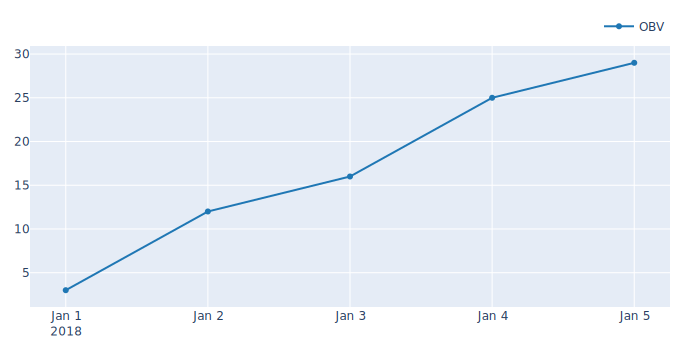

In [104]:
obv['a'].plot().show_svg()